<a href="https://colab.research.google.com/github/skmisht/NLP/blob/main/ner_MITMovieCorpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition 
  - MIT Movie Corpus

In [1]:
# interacting with Operating System
import os
# dataframe module
import pandas as pd
# array processing module
import numpy as np

# matplot plots
import matplotlib.pyplot as plt 
# another plotting module
import seaborn as sns 
# parrameter for visuals
sns.set(color_codes=True)
# parameter for visuals
sns.set(font_scale=1)
%matplotlib inline
# set default image format after ploting
%config InlineBackend.figure_format = 'svg' 

# sklearn
import sklearn
# install sklearn_crfsuite
!pip install sklearn-crfsuite
# sklearn and sklearn_crfsuite
from sklearn_crfsuite import CRF, scorers, metrics
# packeages in crfsuite for the performance rates
from sklearn_crfsuite.metrics import flat_classification_report, flat_accuracy_score
# sklearn package for performance rate
from sklearn.metrics import classification_report, make_scorer
# package for randomized search on hyper parameter
from sklearn.model_selection import RandomizedSearchCV
# package to split the data into train/test
from sklearn.model_selection import train_test_split

# scipy - mathematically use
import scipy.stats

# # eli5 - module to debug machine learning classifiers and to explain thier prediction
# !pip install eli5
# import eli5

# nltk - natural language processing
import nltk
# nltk version
print("nltk {0}".format(nltk.__version__))
# to represent the hierarchical grouping of leaves and subtress
from nltk.tree import Tree
# to convert the CoNll IOB format to a tree
from nltk.chunk import conlltags2tree
# nlltk - to create part of speech tags, 
from nltk import word_tokenize, pos_tag
# nltk executors
# tagger for tagging words with their parts of speech (PoS) tags
nltk.download('averaged_perceptron_tagger')
# package to auto downloads nltk stopwords 
nltk.download('maxent_ne_chunker')
# executor package to work with human language data
nltk.download('words')
# executor package for tokenized sentence that are divided as a texts into a list of sequence
nltk.download('punkt')

     |████████████████████████████████| 747kB 3.9MB/s 
nltk 3.2.5
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load MIT Movie Corpus
  - manualy created Sentence index for movie data
  - Used the one combined file to avoid the overlap and similar data in train & test file. I would have concatenate these file using panda/other package in python but created while I did the sentence indexing.

In [3]:
# declare varaible to store file_path
_mitMovie = '/content/MovieData.txt'

# load data into movieData variable
movieData = pd.read_csv(_mitMovie,
                        names = ['sentences', 'entity_tags', 'words'],
                        sep='\t',
                        header=None, 
                        encoding='latin1')
# display first 5 rows
print("---------- MITMovie Corpus Data --------------")
print(movieData.head())

print() # blank line
print("Data shape {0}".format(movieData.shape))

---------- MITMovie Corpus Data --------------
     sentences entity_tags     words
0  sentence: 1           O       are
1  sentence: 1           O     there
2  sentence: 1           O       any
3  sentence: 1           O      good
4  sentence: 1     B-GENRE  romantic

Data shape (43408, 3)


# Data Exploration
  - Checking if there is any nulls in data
  - Entity tags frequency
  - Histogram: texts distribution by each entity_tags

In [4]:

# check if there is any nulls
print("Nulls seen in the Corpus:\n", movieData.isnull().sum() / movieData.shape[0]*100)

Nulls seen in the Corpus:
 sentences      0.0
entity_tags    0.0
words          0.0
dtype: float64


Note: Based on above output, there has not been detected any missing (NaN/Nulls) into data.

In [5]:
# function to create a table of Frequency count by Named entity tags
def CountFrequency(data):
  """
  Function to count the frequency by named entity tags in corpus.
  Args:
    Data (named entity tags) - a list containing entity tags.
  Returns:
    Frequency by named entity tags in Sentence Corpus.
  """
  # create an empty dict to store the count by entity tags
  tags_freq = {}
  # iterate over each item in list
  for items in data:
    # if item is in dict then increment item esle start as 1
    if items in tags_freq:
      tags_freq[items] += 1
    else:
      tags_freq[items] = 1
  # define column names in table
  print(f"{'Tags':20} Frequency")
  # create divider between column names and the output
  print("---"*10)
  # iterate over items in dict
  for key, value in tags_freq.items():
    print(f"{key:20} {value}")

# call the function - function expects the 
print("----- Frequency by named entity tags ------")
CountFrequency(movieData['entity_tags'])

----- Frequency by named entity tags ------
Tags                 Frequency
------------------------------
O                    26360
B-GENRE              1772
I-GENRE              386
B-YEAR               1132
I-YEAR               808
B-PLOT               798
I-PLOT               745
B-RATINGS_AVERAGE    660
I-RATINGS_AVERAGE    613
B-ACTOR              1337
I-ACTOR              1415
B-TITLE              1448
I-TITLE              2242
B-SONG               144
B-CHARACTER          228
B-RATING             712
I-RATING             318
B-REVIEW             171
B-DIRECTOR           717
I-DIRECTOR           755
I-REVIEW             94
I-SONG               270
I-CHARACTER          189
B-TRAILER            82
I-TRAILER            12


The above frequency table indecates that there is a maximum count for named entity tagged aas "O" which means "Outside of the chunk means that token does not belongs to the chunk. Let's see how the distribution without "O" looks in graph below.

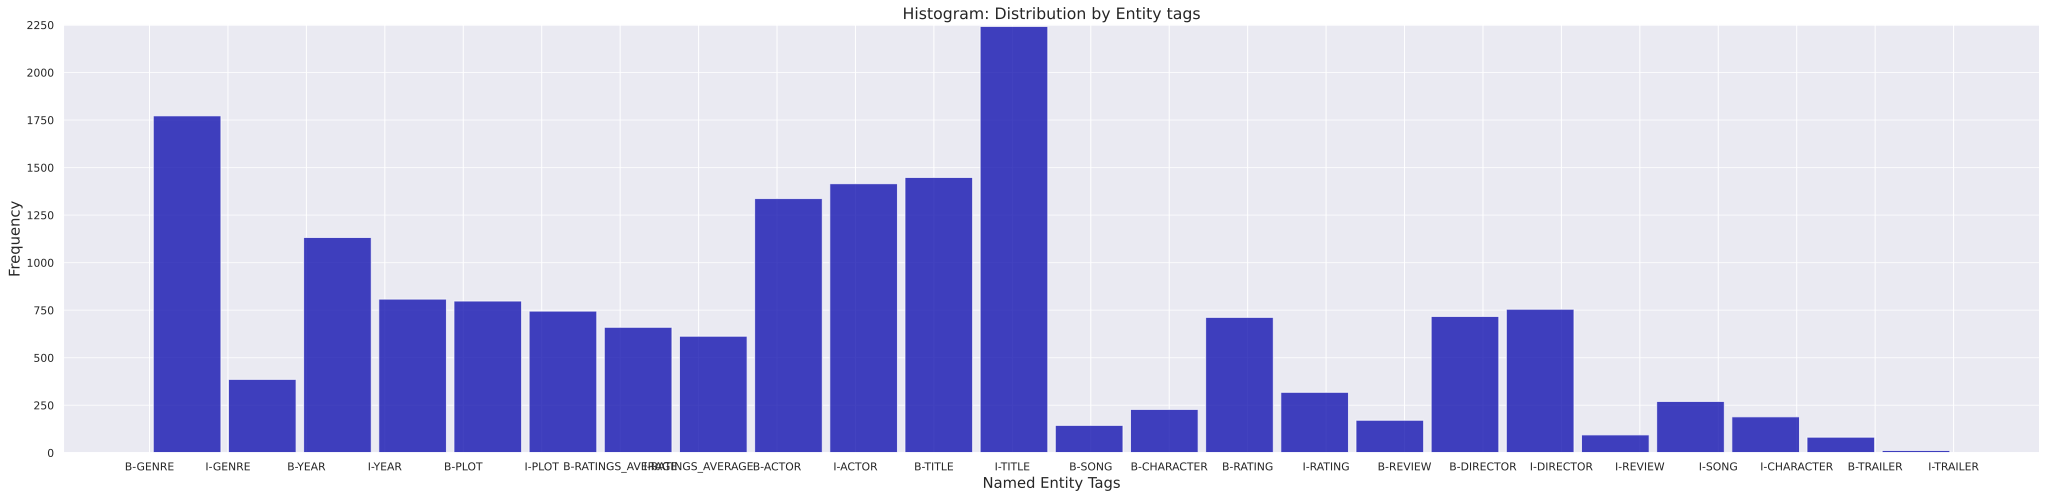

In [6]:
# plotting Frequency: Histogram - tags Distribution
def entityHistogram(data, num_bins=None):
    """
    Function to plot the histogram of named entity tags distribution.
    Args:
        Data (named entity tags) - a list containing entity tags.
    Returns:
        Histogram - Named Entity tags distribution.
    """
    # tags as labels
    labels = data.unique()
    # figure size
    plt.figure(figsize=(36, 8))
    # if the bins value is not None
    if num_bins is not None:
        n, bins, patches = plt.hist(x = data, bins = num_bins, color='#0504aa', alpha = 00.75, rwidth = 0.9)
    # else no bins value is provided
    else:
        print("Number of bins required is not defined!")
    # set title
    plt.title("Histogram: Distribution by Entity tags", fontsize = 16)
    # set grids
    plt.grid(axis='y', alpha=0.75)
    # set y position
    y_pos = np.arange(len(labels))
    # set current tick location
    plt.xticks(y_pos , labels)
    # set x & y axis labels 
    plt.ylabel('Frequency' , fontsize = 15)
    plt.xlabel('Named Entity Tags', fontsize=15)
    # compute frequency
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    
# call entityHistogram() on training data
movieData_withoutO = movieData[movieData['entity_tags'] != 'O']
entityHistogram(movieData_withoutO['entity_tags'], num_bins=24)

Above histogram shows an evidence of imbalance class in data. 

# NLTK Entity Detection
Main steps:
  - Creating PoS tags
  - Parsing into IOB format of tree using Conlltags2tree
  - Detecting named entity tags as per the text

In [7]:
# define function to create the PoS tags
def createPoS(data):
  """
  Function to create the PoS tags based on tokenized text.
  Args:
    Data (Words): a list of words
  Returns:
    PoS tags: a list containing PoS tags for each words.
  """
  # try to create PoS tags for each words
  try:
    pos_tags = [pos for data, pos in pos_tag(data)]
    # return create PoS tags
    return pos_tags
  # Exception
  except Exception as error:
    print(str(error))

# converts words tokens into list of words token
word_token_list = movieData['words'].tolist()
# call a createPoS() function
pos_tags = createPoS(word_token_list)
# display first 10 PoS tags
print("Sample of created PoS tags: ", pos_tags[:10])
# blank line
print()
# add into the movieData dataframe 
movieData['pos_tags'] = pos_tags
# structure the dataframe as the per conlltags corpus
movieData = movieData[["sentences", "words", "pos_tags", "entity_tags"]]
# display the first 10 rows
print(movieData.head(10))

Sample of created PoS tags:  ['VBP', 'RB', 'DT', 'JJ', 'JJ', 'NNS', 'RP', 'RB', 'RB', 'VB']

     sentences     words pos_tags entity_tags
0  sentence: 1       are      VBP           O
1  sentence: 1     there       RB           O
2  sentence: 1       any       DT           O
3  sentence: 1      good       JJ           O
4  sentence: 1  romantic       JJ     B-GENRE
5  sentence: 1  comedies      NNS     I-GENRE
6  sentence: 1       out       RP           O
7  sentence: 1     right       RB      B-YEAR
8  sentence: 1       now       RB      I-YEAR
9  sentence: 2      show       VB           O


In [8]:
# function to parse the tags into conlltags tree
def create_conlltags_tree(list_1, list_2, list_3):
    """
    Function to create conlltags2tree.
    Args:
        list_1: entity_tags
        list_2: tokens (words)
        list_3: PoS tags
    """
    # try to create conlltags2tree
    try:
        # create tuples of lists and store into conlltags variable
        conlltags = [(token, pos, tags) for token, pos, tags in zip(list_1, list_2, list_3)]
        # instantiate conlltags2tree class and store into ne_tree (named entity tree)
        ne_tree = conlltags2tree(conlltags)
        # return name entity tree after storing into ne_tree variable
        return ne_tree
    # Exception
    except Exception as error:
        print(str(error))


# creating namedEntity tags list
namedEntity_tags = movieData['entity_tags'].tolist()
# instantiate fucntion
conlltag_tree = create_conlltags_tree(word_token_list, pos_tags, namedEntity_tags)
# display PoS tags for first 10 words
conlltag_tree[:20]

[('are', 'VBP'),
 ('there', 'RB'),
 ('any', 'DT'),
 ('good', 'JJ'),
 Tree('GENRE', [('romantic', 'JJ'), ('comedies', 'NNS')]),
 ('out', 'RP'),
 Tree('YEAR', [('right', 'RB'), ('now', 'RB')]),
 ('show', 'VB'),
 ('me', 'PRP'),
 ('a', 'DT'),
 ('movie', 'NN'),
 ('about', 'IN'),
 Tree('PLOT', [('cars', 'NNS'), ('that', 'WDT'), ('talk', 'VBP')]),
 ('list', 'IN'),
 ('the', 'DT'),
 Tree('RATINGS_AVERAGE', [('five', 'CD'), ('star', 'NN')]),
 ('rated', 'VBN'),
 ('movies', 'NNS'),
 ('starring', 'VBG'),
 Tree('ACTOR', [('mel', 'NN'), ('gibson', 'NN')])]

Now we can detect the named entitiy tags (IOB/BIO) usign the chunker conlltags2tree

In [9]:
# parse name entities from the tree
def DetectNamedEntity(data):
    """
    Function to detect the named entity tags corresponding to the words.
    Args:
        Data: ne_tree varible which stores the conlltags tree.
    Return:
        Detected entity tags corresponding to the words.
    """
    # create an empty list
    namedEntity_list = []
    # iterate over the tree - call from create_conlltags_tree()
    for trees in data:
        # condition - skip the 'O' tags - if subtree is a noun chunnk
        if type(trees) == Tree:
            # initialise tree labels
            labels = trees.label()
            # join with tokens (words) and PoS tags in tree's leaves
            string = " ".join([token for token, pos in trees.leaves()])
            # # append string and labels as tuples into empty list
            namedEntity_list.append((string, labels)) 
    # return appended list
    return namedEntity_list

# call StructureNamedEntity() and display named entity
detectNamedEntities = DetectNamedEntity(conlltag_tree)
# title
print(" ---- Movie data named entity detected ------")
# first 10 elements from tuples
detectNamedEntities[:20]

 ---- Movie data named entity detected ------


[('romantic comedies', 'GENRE'),
 ('right now', 'YEAR'),
 ('cars that talk', 'PLOT'),
 ('five star', 'RATINGS_AVERAGE'),
 ('mel gibson', 'ACTOR'),
 ('science fiction', 'GENRE'),
 ('recently', 'YEAR'),
 ('harry potter', 'TITLE'),
 ('1980s', 'YEAR'),
 ('action', 'GENRE'),
 ('star trek series', 'TITLE'),
 ('soundtrac', 'SONG'),
 ('harry potter films', 'TITLE'),
 ('science fiction', 'GENRE'),
 ('since 2005', 'YEAR'),
 ('current', 'YEAR'),
 ('mat damon', 'ACTOR'),
 ('jim carrey', 'ACTOR'),
 ('detective', 'CHARACTER'),
 ('george clooney', 'ACTOR')]

# What is CRF?
CRF is the probabilistic model for segmenting and labeling sequence data. As in the Sequence Classification problem, the main goal is to find the probability of a sequence of label (y) given an input of sequence vectors (X) which is denoted as p(y|x). 

# Feature function in CRF
In a CRF, each feature fucntion is a function that takes in as input:
  - s: sentence
  - i: ith position of word in the sentence
  - l(i): the label of current word
  - l(i−1): the label of the previous word
  - expected output is a real valued number either 0 or 1

# Features to Probability
How actually the CRF works?
  - Firstly, we assign each feature function f(j) a weight λ(j). 
  - Now given a sentence (s), we can score a labeling (l) of sentence (s) by adding up the weighted features over all words in the sentence. Below screen shot shows the exampl eof scoring the labels and sentence by addign the weighted features:

    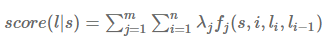

Note: first sum runs over each feature function (j), and second sum runs over each position (i) of the sentence.

  - Now we tranform these scores into probabilities as p(l|s) between 0 and 1 by exponentiating and normalizing. Below equation shows the transformation of scores into probablities:
  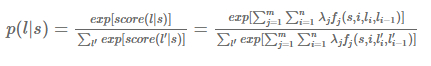

# How the process works?
 - f1(s,i,l(i),l(i−1)) = 1 if l(i) == ADVERB and ith words ends in "ly", otherwise it is 0, -->> if weight λ1 associated with this feature is large and positive, then this feature is essentially saying that assign the labellings "ADVERB" where where words ending in "-ly". 
- same with the NOUN, VERB, and PREPOSITION

# sklearn_crfsuite classifier
CRF (Conditional random fields) is a framework for building models to segment and label sequence data. 

Main steps:
  - Data pre-processing for sklearn-crfsuite
    - Retreive sentence corresponding to tags
    - Parsing features (parameters) to sentence corpus
    - splitting data into train/test
  - Training CRF with hyper-parameters of:
    - 'lbfgs' - Gradient descent using L-BFGS method
    - Regularisations:
      - c1: coefficient for L1 regularisation
      - c2: coefficient for L2 regularisation
    - max_iteration: 100 -> maximum number of iteration for optimzation algorithm
    - all_posible_transition: True -> generates transition features that associate all of posible label pairs.
  - Model Evaluation
    - Step 1: removing "O" tag from named entity
    - Step 2 - Performance metrics:
      - F1-Score
      - Performance per each class (classfication report)

  - CRF model after hyper-parameters optimzation
    - Hyper parameters:
      - Training to select best regularisation parameter
      - Cross validation fold (cv=3)
      - n_iteration 50 so 150 fits in total (50*3)
    - Model prediction after optimization
      - Performance metrics:
        - F1-Score
        - Performance per each class (classification report)

Data pre-processing for sklearn-crfsuite
  - Retreive sentence corresponding to tags
  - Parsing features (parameters) to sentence corpus
  - splitting data into train/test

In [10]:
# sentenceGetter class to retreive sentence corresponding to tags
class sentenceGetter(object):
  """
  Movie Corpus object containing words, entity_tags, PoS_tags.
  param args: (str)
      Data - lists of words, entity_tags, and PoS_tags.
  """
  # define initialiser
  def __init__(self, data):
    """ Initialiser."""
    self.n_sent = 1
    self.data = data
    self.empty = False
    # lmbda function to apply aggregate function - function zips the features into lists with corresponding sentence
    agg_func = lambda sentence: [(texts, posTags, entityTags) for texts, posTags, entityTags in zip(sentence['words'].values.tolist(),
                                                                                                    sentence['pos_tags'].values.tolist(),
                                                                                                    sentence['entity_tags'].values.tolist())]

    # grouping data by sentence index and applying the lambda function for aggregation
    self.grouped = self.data.groupby("sentences").apply(agg_func)
    # get the sentence in tuples with corresponding word, postags and entity tags
    self.sentences = [sentence for sentence in self.grouped]

    # getter()
    def get_next(self):
      """
      Function getter() - traverse over the sentence corpus.
      """
      try:
        sentences = self.grouped["sentence: {}".format(self.n_sent)]
        # increment n_snet by 1
        self.n_sent += 1
        # reuturn sentence
        return sentences
      # Exception
      except Exception as error:
        print(str(error))

# instantiate the class
getter = sentenceGetter(movieData)
# traverse the corpus and get next sentence
SentenceCorpus = getter.sentences
# display sentence as per list of sentences index
SentenceCorpus[0]

[('are', 'VBP', 'O'),
 ('there', 'RB', 'O'),
 ('any', 'DT', 'O'),
 ('good', 'JJ', 'O'),
 ('romantic', 'JJ', 'B-GENRE'),
 ('comedies', 'NNS', 'I-GENRE'),
 ('out', 'RP', 'O'),
 ('right', 'RB', 'B-YEAR'),
 ('now', 'RB', 'I-YEAR')]

In [11]:
# Function to parse features (parameters) to sentence corpus
def word2features(corList, i):
    """
    Function to parse features to sentence corpus like word suffix, identity, shape and PoS tags.
    Args:
        Sentence Corpus: (str) tuples containing Sentence Corpus.
    Returns: 
        Dict of Extracted features to be apply to Corpus.
    """
    # word variable to store words from corpus at index level
    word = corList[i][0]
    # postag variable to storer PoS tags from corpus at index level
    postag = corList[i][1]
    # dict - containing features to be apply on corpus
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    # if index > 0 
    if i > 0:
        # traverse over the word corpus by start index
        word1 = corList[i-1][0]
        # traverse over the PoS tags corpus by start index
        postag1 = corList[i-1][1]
        # update the features in corpus
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word[-3:]': word1[-3:],
            '-1:word[-2:]': word1[-2:],
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    # else begining of sentence
    else:
        features['BOS'] = True
    # if index is less than len of corpus
    if i < len(corList)-1:
        # 
        word1 = corList[i+1][0]
        postag1 = corList[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word[-3:]': word1[-3:],
            '+1:word[-2:]': word1[-2:],
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    # else End of sentence
    else:
        features['EOS'] = True
    # return extracted features
    return features

# define sentence features
def sent2features(corList):
    """
    Function to parse the extracted features to input words corpus.
    """
    return [word2features(corList, i) for i in range(len(corList))]
# define sentence labels
def sent2labels(corList):
    """
    Function to parse the labels.
    """
    return [label for token, postag, label in corList]

# sanity check - call sent2feautres() - to see what features are extracted
print("----- Extracted featurs are --------")
sent2features(SentenceCorpus[0])[0]

----- Extracted featurs are --------


{'+1:postag': 'RB',
 '+1:postag[:2]': 'RB',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': 'there',
 '+1:word[-2:]': 're',
 '+1:word[-3:]': 'ere',
 'BOS': True,
 'bias': 1.0,
 'postag': 'VBP',
 'postag[:2]': 'VB',
 'word.isdigit()': False,
 'word.istitle()': False,
 'word.isupper()': False,
 'word.lower()': 'are',
 'word[-2:]': 're',
 'word[-3:]': 'are'}

In [12]:
# splitting data
def split_data(data, test_ratio=None, random_state=42):
  """
  Function to split data into train/test.
  Args:
      Data: Sentence Corpus (tuples)
      Split ratio (float)
  Returns:
      Train/Test splits
  """
  # call sent2features() for input features
  inputFeatures = [sent2features(input) for input in data]
  # call sent2labels() for target labels
  targetLabels = [sent2labels(labels) for labels in data]
  # make split between train and test
  x_train, x_test, y_train, y_test = train_test_split(inputFeatures, targetLabels, test_size = test_ratio, random_state = random_state)
  # if the test_size ratio is provided then split data between train and tests
  if test_ratio != None:
    return x_train, x_test, y_train, y_test
  else:
    print("Error: Split ratio is not defined!")

# call function split_data()
x_train, x_test, y_train, y_test = split_data(SentenceCorpus, 0.3)
# display extracted input features
print(x_train[:1])
print() # blank line
print(y_train[:1])

print() # blank line
print("----- Data is sent for train and testing ------ ")
# data size
print("x_train: ", len(x_train))
print("x_test: ", len(x_test))
print("y_train: ", len(y_train))
print("y_test: ", len(y_test))

[[{'bias': 1.0, 'word.lower()': 'did', 'word[-3:]': 'did', 'word[-2:]': 'id', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'VBD', 'postag[:2]': 'VB', 'BOS': True, '+1:word.lower()': 'the', '+1:word[-3:]': 'the', '+1:word[-2:]': 'he', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'DT', '+1:postag[:2]': 'DT'}, {'bias': 1.0, 'word.lower()': 'the', 'word[-3:]': 'the', 'word[-2:]': 'he', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'DT', 'postag[:2]': 'DT', '-1:word.lower()': 'did', '-1:word[-3:]': 'did', '-1:word[-2:]': 'id', '-1:word.istitle()': False, '-1:word.isupper()': False, '-1:postag': 'VBD', '-1:postag[:2]': 'VB', '+1:word.lower()': 'shining', '+1:word[-3:]': 'ing', '+1:word[-2:]': 'ng', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'NN', '+1:postag[:2]': 'NN'}, {'bias': 1.0, 'word.lower()': 'shining', 'word[-3:]': 'ing', 'word[-2:]': 'ng', 'word.isupper()'

Training CRF with hyper-parameters of:
  - **'lbfgs' - Gradient descent using L-BFGS method**: is an optimization algorithm in the family of quasi-Newton methods that approximates the “Broyden-Fletcher-Goldfarb-Shanno algorithm (BFGS)” using a limited amount of computer memory. It is a popular algorithm for parameter estimation in ML. The algorithm’s target problem is to minimize f(x) over unconstrained values of the real-vector (x) where (f) is a differentiable scalar function. 
Like the original BFGS, L-BFGS uses an estimate of the inverse Hessian matrix to steer its search through variable space, but where BFGS stores a dense (n*n) approximation to the inverse Hessian (n being the number of variables in the problem). L-BFGS stores only a few vectors that represent the approximation implicity. Due to its linear memory requirement, the L-BFGS method is particularly well suited for optimization problems with many variables. Instead of the inverse Hessian (H^k), L-BFGS maintains a history of the past (m) updates of the position (x) and gradient f(x), where generally the history size (m) can be small (often m < 10).  

  - **Regularisations**:
    - **c1: coefficient for L1 regularisation** - adds a penalty equal to the “absolute value” of the magnitude of coefficients, in simple words, it reduces the size of the coefficients. L1 yields sparse models i.e. models with few coefficients, some coefficients can become zero and eliminate. 
    - **c2: coefficient for L2 regularisation** - adds an L2 penalty equal to the square of the magnitude of coefficients. L2 will not yield sparse models and all coefficients are shrunk by the same factor (none are eliminated).
  - **max_iteration**: 100 -> maximum number of iteration for optimzation algorithm
  - **all_posible_transition**: True -> generates transition features that associate all of posible label pairs.

In [13]:
%%time
# define CRF model
def crfSuiteParam():
  """Function to define hyperparameter for Optimzation."""
  # define parameter for optimzation
  parameters = CRF(
      # gradient descent using L-BFGS method
      algorithm = 'lbfgs',
      # L1 regularisation
      c1= 0.1,
      # L2 regularisation
      c2 = 0.1,
      # maximum number of iteration for optimzation algorithm
      max_iterations = 50,
      # generates transition features that associate all of posible label pairs
      all_possible_transitions=True, 
      verbose = 1
  )
  # return CRF with hyper-parameters
  return parameters

# instantiate crfSuiteParameter()
crf = crfSuiteParam()
# fit model
crf.fit(x_train, y_train)

loading training data to CRFsuite: 100%|██████████| 3250/3250 [00:00<00:00, 6716.12it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 33685
Seconds required: 0.136

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 50
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.23  loss=71870.86 active=33200 feature_norm=1.00
Iter 2   time=0.36  loss=54977.87 active=32810 feature_norm=2.73
Iter 3   time=0.13  loss=50538.07 active=31765 feature_norm=2.43
Iter 4   time=0.12  loss=47819.53 active=32686 feature_norm=2.69
Iter 5   time=0.12  loss=37671.73 active=32231 feature_norm=5.43
Iter 6   time=0.12  loss=30875.11 active=32476 feature_norm=7.72
Iter 7   time=0.12  loss=23079.24 active=32502 feature_norm=12.66
Iter 8   time=0.13  loss=20351.98 active=32415 feature_norm=15.52
Iter 9   time=0.12  loss=18239.22 active=32807 feature_norm=16.94
Iter 10  tim

Model Evaluation
  - Step 1: removing "O" tag from named entity
  - Step 2 - Performance metrics:
      - F1-Score: weighted average of Precision and Recall, and takes both false positive and false negative into account.  
      - Performance per each class (classfication report)

In [14]:
# variable to store a list of classes
target_labels = list(crf.classes_)
#  step 1 - remove entity tagged as "O"
target_labels.remove("O")
# display target classes after removing "O"
print(target_labels)

['B-TITLE', 'I-TITLE', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'B-SONG', 'B-PLOT', 'B-GENRE', 'B-TRAILER', 'B-YEAR', 'I-YEAR', 'B-DIRECTOR', 'I-DIRECTOR', 'I-PLOT', 'B-RATING', 'B-ACTOR', 'I-ACTOR', 'B-REVIEW', 'I-REVIEW', 'I-GENRE', 'I-RATING', 'I-SONG', 'B-CHARACTER', 'I-CHARACTER', 'I-TRAILER']


In [15]:
# avoiding warnings that is treated differently from an error - likely to get as I have removed the entity tag "O" from classes
import warnings
warnings.filterwarnings('ignore')
# sklearn_crfsuite
import sklearn_crfsuite

In [16]:
  predData = crf.predict(x_test[1])
  print(predData)
  print(y_test[1])

[['B-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT'], ['B-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT'], ['B-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT'], ['B-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT'], ['B-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT', 

In [17]:
# Model Evaluation - Performance metrics - precision, recall, f1_score per each class without "O"
def PerformancePerClass(model, x_test, y_test): #, labels):
  """
  Function to evaluate and validate the CRF model.
  Args:
      model: crf (defined classifier)
      x_test (list)
      y_test: (list)
  Returns:
      f1_score
      Performance rates (Classification report)
  """
  # prediction
  predData = model.predict(x_test)
  # get f1-Score
  f1Score = sklearn_crfsuite.metrics.flat_f1_score(y_test, predData, average='weighted') #, labels = labels)
  # Classification Report
  perfRates = sklearn_crfsuite.metrics.flat_classification_report(y_test, predData, digits=2) #, labels= labels)
  # return f1Score, classification report
  return f1Score, perfRates


# model - crf
# call function - PerformancePerClass()
f1_Score, performanceByClass = PerformancePerClass(crf, x_test, y_test) #, target_labels)
# display f1_score
print(f"F1 Score: {f1_Score:.2}")
print() # blank line
# display Classification report
print("----- Performance rates per Class --------:\n", performanceByClass)

F1 Score: 0.89

----- Performance rates per Class --------:
                    precision    recall  f1-score   support

          B-ACTOR       0.84      0.89      0.86       390
      B-CHARACTER       0.63      0.52      0.57        69
       B-DIRECTOR       0.87      0.78      0.82       216
          B-GENRE       0.91      0.91      0.91       542
           B-PLOT       0.65      0.49      0.55       251
         B-RATING       0.95      0.91      0.93       212
B-RATINGS_AVERAGE       0.83      0.80      0.81       200
         B-REVIEW       0.34      0.24      0.29        49
           B-SONG       0.81      0.47      0.59        45
          B-TITLE       0.74      0.73      0.74       419
        B-TRAILER       0.95      0.78      0.86        23
           B-YEAR       0.92      0.89      0.90       354
          I-ACTOR       0.84      0.86      0.85       422
      I-CHARACTER       0.58      0.42      0.49        59
       I-DIRECTOR       0.86      0.81      0.84     

CRF model after hyper-parameters optimzation
  - Hyper parameters:
    - Training to select best regularisation parameter
    - Cross validation fold (cv=3)
    - n_iteration 50 so 150 fits in total (50*3)

In [18]:
%%time
# define function for hyper-parameter optimzation which includes fixed pararmeters and parameter to search for
def RandomSerachCV(labels):
  """
  Function for hyper-parameter optimzation.
  Args:
    Labels: list of target labels (without "O")
  Returns:
    Best hyper-parameter where model achieved the good results.
  """
  crfParams = CRF(
      # gradient descent using L-BFGS method
      algorithm = 'lbfgs',
      # maximum number of iteration for optimzation algorithm
      max_iterations = 50,
      # generates transition features that associate all of posible label pairs
      all_possible_transitions=True, 
  )

  # define regularisation parameters
  paramSpace = {
      # L1 regularisation
      'c1': scipy.stats.expon(scale=0.5),
      # L2 regularisation
      'c2': scipy.stats.expon(scale=0.05),
  }
  # same for evaluation
  f1_score = sklearn.metrics.make_scorer(sklearn_crfsuite.metrics.flat_f1_score, 
                                         average='weighted', 
                                         labels=labels)
  # grid search for parameter
  paramSearch = RandomizedSearchCV(crfParams,
                                   paramSpace, 
                                   cv=3, 
                                   verbose=1,
                                   n_jobs=-1, 
                                   n_iter=50,
                                   scoring=f1_score)
  return paramSearch

# instantiate RandomSerachCV()
parameterSearch = RandomSerachCV(labels =target_labels)
# fit on training data
parameterSearch.fit(x_train, y_train)

# best parameter results found
print("Best Parameters: ", parameterSearch.best_params_)
print("Best CV Score: ", parameterSearch.best_score_)
print("Model Size: {:0.2f}M".format(parameterSearch.best_estimator_.size_ / 1000000))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 17.5min finished


Best Parameters:  {'c1': 0.1520143426563568, 'c2': 0.0691198648973362}
Best CV Score:  0.7828193414233454
Model Size: 1.00M
CPU times: user 13min 22s, sys: 2.27 s, total: 13min 24s
Wall time: 17min 37s


Model prediction after optimization
  - Performance metrics:
    - F1-Score
    - Performance per each class (classification report)

In [19]:
# model
modelAfterOptimzation = parameterSearch.best_estimator_
# call function - PerformancePerClass() function
f1_Score, performanceByClass = PerformancePerClass(modelAfterOptimzation, x_test, y_test) #, target_labels)
# display f1_score
print(f"F1 Score: {f1_Score:.2}")
print() # blank line
# display Classification report
print("----- Performance rates per Class --------:\n", performanceByClass)

F1 Score: 0.89

----- Performance rates per Class --------:
                    precision    recall  f1-score   support

          B-ACTOR       0.85      0.89      0.87       390
      B-CHARACTER       0.64      0.51      0.56        69
       B-DIRECTOR       0.87      0.79      0.83       216
          B-GENRE       0.91      0.90      0.91       542
           B-PLOT       0.67      0.49      0.57       251
         B-RATING       0.96      0.92      0.93       212
B-RATINGS_AVERAGE       0.82      0.81      0.81       200
         B-REVIEW       0.33      0.27      0.30        49
           B-SONG       0.79      0.51      0.62        45
          B-TITLE       0.74      0.74      0.74       419
        B-TRAILER       0.86      0.83      0.84        23
           B-YEAR       0.92      0.88      0.90       354
          I-ACTOR       0.86      0.86      0.86       422
      I-CHARACTER       0.60      0.41      0.48        59
       I-DIRECTOR       0.85      0.81      0.83     

# Bi-LSTM (Bidirectional-Long Short Term Memory)
Understanding LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

# What is LSTM?
LSTMs are the special kind of RNN, and capable of learning long term dependencies, and are explicitly designed to avoid the Long-Term dependencies means remembering information for long periods of time is practically their behaviour.

LSTMs contains 4 interacting layers in which 3 for sigmoid and 1 of tanh layer as compared to the traditional RNN with 1 tanh layer.

# Core Idea behind LSTM
  - LSTM is the cell state, and does have the ability to remove or add information to the cell state carefully regulated by structure called "Gates". 
  - Gates are a way to optionally let information through. They are composed out of a Sigmoid neural network layer and pointwise multiplication operation.
  - Sigmoid layer outputs number between 0 and 1, where 0 means "let nothing through", and 1 meansd "let everything through". 
  - LSTM has 3 gates to protect and control the cell state.

# Main Steps in LSTM
- The first step in LSTM is to decide what information we are going to throw away from the cell state. This decision is made by a "Sigmoid layer called "Forget Gate Layer"". This layer looks at the values between 0 and 1 for each number in cell state. 
- The next step is to decide what new information we are going to store in the cell state, which has 2 parts: 
  - Sigmoid layer called "input gate layer", decides which values we will update.
  - Next "tanh" layer, creates vector of now candidate values, which might be added to the state.
- So after that the process consists of: we run Sigmoid layer which decide what parts of the cell state we are going to output.
- Then put the cell state through the "tanh" to push the values between -1 and 1, and multiplying it by the output of the Sigmoid Gate so that we only output the parts we decide to. 

For this assesment, I have used Bi-LSTM which is an extension of a traditional LSTM.

Bi-LSTMs trains two instead of one LSTMs on the input sequence:
  - First on the input sequence as-is as input to the first layer.
  - Second on a reversed copy of the input sequence to the second layer.

This can provide additional context to the network and result in faster and even fuller learing on the problem. The main use of providing the sequence Bi-LSTM was initially justified in the domain of Speech recoignition because there is evidence that the context of the whole utterance is used to interpret what is being sadi rather than a linear interpretation.

In [20]:
# required packages
# tensorflow
import tensorflow as tf
# version check
print("tensorflow {}".format(tf.__version__))
# if GPU available
print("GPU: ", tf.config.list_physical_devices("GPU"))
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# livelossplot package - for live training loss
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

# scikit-learn
from sklearn.model_selection import train_test_split

tensorflow 2.5.0
GPU:  []


# Data (same data used for CRF model)

In [21]:
print(movieData.head())
print() # blank line
print("Data shape {0}".format(movieData.shape))
print("Unique sentences count: ", movieData['words'].nunique())
print("Unique named entity tags count: ", movieData['entity_tags'].nunique())

     sentences     words pos_tags entity_tags
0  sentence: 1       are      VBP           O
1  sentence: 1     there       RB           O
2  sentence: 1       any       DT           O
3  sentence: 1      good       JJ           O
4  sentence: 1  romantic       JJ     B-GENRE

Data shape (43408, 4)
Unique sentences count:  4463
Unique named entity tags count:  25


# Sentence Corpus (Same Corpus that was used in CRF model)

In [22]:
SentenceCorpus[0]

[('are', 'VBP', 'O'),
 ('there', 'RB', 'O'),
 ('any', 'DT', 'O'),
 ('good', 'JJ', 'O'),
 ('romantic', 'JJ', 'B-GENRE'),
 ('comedies', 'NNS', 'I-GENRE'),
 ('out', 'RP', 'O'),
 ('right', 'RB', 'B-YEAR'),
 ('now', 'RB', 'I-YEAR')]

# Define Hyper-parameters for Bi-LSTM
  - max_length: maximum length of sentence in corpus
  - embedding_dim: dimension of embedding
  - num_epochs: number of epochs
  - batch_size: number of batch for trails error
  - trunc_type: put dimension into same size (if not replacing by 0)
  - padding_type: pad dimension into same size (if not replcaed by 0)

In [23]:
# max_length - maximum length of sequence in corpus
max_length = max([len(sentence) for sentence in SentenceCorpus])
print("Maximum length of sequence in Corpus: ", max_length)
# define input_dim
input_dimension = list(set(movieData['words'].values))
# append with padding to the end
input_dimension.append("ENDPAD")
print("Input dimension: ", len(input_dimension))
# number of classes
num_classes = len(list(set(movieData['entity_tags'])))
print("Number of classes for flatten layer: ", num_classes)
# embedding_dim = 200 # recommended value
# padding and truncating type -- imp paper: https://arxiv.org/pdf/1903.07288.pdf
trunc_type = "post"
padding_type = "post"

Maximum length of sequence in Corpus:  38
Input dimension:  4464
Number of classes for flatten layer:  25


# Data Preprocessing for Bi-LSTM
  - Define list of unique words and tags [for hyper-parameter reference if required]
  - Get the input and target features
  - Split data into training and test sets

Define list of unique words and tags for hyper-parameter reference

In [24]:
# Creating lists of Unique words and tags
words = list(set(movieData['words'].values))
# append list with padding at the end
words.append("ENDPAD")
# store len of words_list into a variable
num_words = len(words)
# unique tags that we have
tags = list(set(movieData['entity_tags'].values))
# store len of tags list into a variable
num_tags = len(tags)
# display appended words and tags
num_words, num_tags

(4464, 25)

Get an Input and Target features

In [25]:
# functio to define mapping between sentences and entity tags - get the input and target 
def processData(Data, Corpus):
  # define the list of unique words
  texts = list(set(Data['words'].values))
  # define the list of unique tags
  tags = list(set(Data['entity_tags'].values))
  # get words and tags by index
  word_index = {word:index+1 for index, word in enumerate(texts)}
  tags_index = {tag:index for index, tag in enumerate(tags)}
  # get the input and target feature out from SentenceCorpus
  inputFeatures = [[word_index[word[0]] for word in sentence] for sentence in Corpus] # 0 index for sentence in SentenceCorpus
  targetFeatures = [[tags_index[word[2]] for word in sentence] for sentence in Corpus] # 2 index for tags in SentenceCorpus
  # define padding
  inputs = pad_sequences(inputFeatures, padding = padding_type, maxlen=max_length, truncating=trunc_type, value=len(texts)-1)
  target = pad_sequences(targetFeatures, padding = padding_type, maxlen=max_length, truncating=trunc_type, value=tags_index["O"])
  # convert target feature into categorical feature
  target = [to_categorical(index, num_classes=num_classes) for index in target]

  # return input and target features
  return inputs, target

# call processData()
X, y = processData(movieData, SentenceCorpus)
# display input faeture
print("Input features after processing:\n ", X[1])
print() # blank line
# display target feature
print("Target feature after processing:\n ", y[1])

Input features after processing:
  [3778  152 1711  533 3969 1723 4191 1365 2022 4462 4462 4462 4462 4462
 4462 4462 4462 4462 4462 4462 4462 4462 4462 4462 4462 4462 4462 4462
 4462 4462 4462 4462 4462 4462 4462 4462 4462 4462]

Target feature after processing:
  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0

Data split data between train/test sets
  - 80:20

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("x_train: ", x_train.shape)
print("y_train: ", len(y_train))
print("x_test: ", x_test.shape)
print("y_test: ", len(y_test)) 

x_train:  (3714, 38)
y_train:  3714
x_test:  (929, 38)
y_test:  929


# Build Bi-LSTM
- Using pre-defined hyper-parameters for Bi-LSTM

- Bidirectional layer
  - Units: (128) number of neurons
  - return_sequence: (True) means return sequence rather than single values
  - recurrent_dropout: regularisation for bi-lstm layer to prevent from overfitting

- TimeDistributed: as the layer wrapper which allows us to apply a layer to every temporal slice of an input. Or in simple words, it applies a same Dense (fully conected) operation to every timestamp of a 3D tensor.

In [27]:
# define fucntion to build the Bidirectional model
def BiLSTM():
  """
  Function to build Bidirectional LSTM model.
  """
  # define input layer
  input_words = Input(shape=(max_length, ))
  # define word embedding layer
  model = Embedding(input_dim=len(input_dimension), output_dim=max_length, input_length=max_length)(input_words)
  # apply dropout layer - drops entire 1D feature maps instead of individual elements
  model = SpatialDropout1D(0.1)(model)
  # define Bidirectional layer
  model = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1))(model)
  # define output layer
  output = TimeDistributed(Dense(num_classes, activation='softmax'))(model)
  # define Keras model
  model = Model(input_words, output)
  # return model
  return model

# Instantiate model
model = BiLSTM()
# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 38)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 38, 38)            169632    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 38, 38)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 38, 256)           171008    
_________________________________________________________________
time_distributed (TimeDistri (None, 38, 25)            6425      
Total params: 347,065
Trainable params: 347,065
Non-trainable params: 0
_________________________________________________________________


Model Architect

Defined Bi-LSTM architect:->


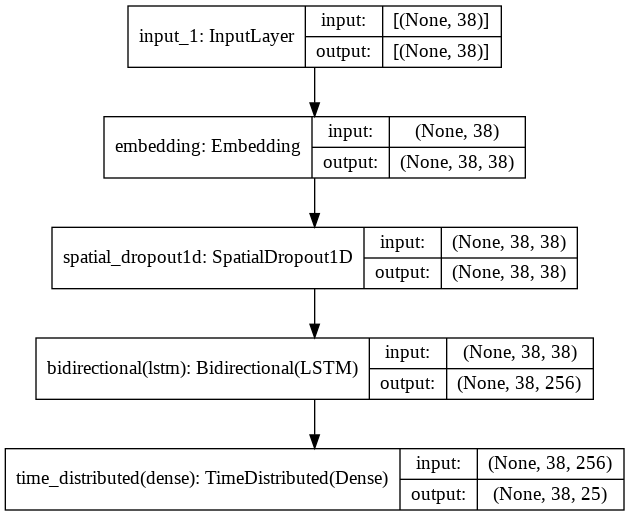

In [28]:
from tensorflow.keras.utils import plot_model
print("Defined Bi-LSTM architect:->")
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training Model
- Optimization algorithm: Adam (calculates an exponential moving average of the gradient and squared gradient.)
- Loss function: categorical_crossentropy (for multi-class classification) 
- Metrics: Accuracy (% of examples correctly classified)
- Validation split of 80:20
- Number of Epochs: 10
- Batch size: 20

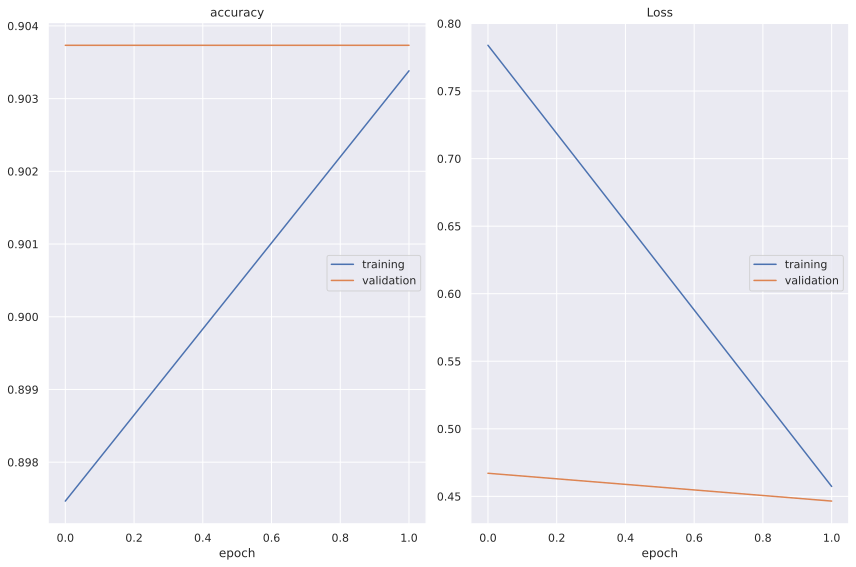

accuracy
	training         	 (min:    0.897, max:    0.903, cur:    0.903)
	validation       	 (min:    0.904, max:    0.904, cur:    0.904)
Loss
	training         	 (min:    0.457, max:    0.784, cur:    0.457)
	validation       	 (min:    0.446, max:    0.467, cur:    0.446)


{'accuracy': [0.8974649906158447, 0.9033818244934082],
 'loss': [0.7838663458824158, 0.4573471248149872],
 'val_accuracy': [0.9037330746650696, 0.9037330746650696],
 'val_loss': [0.46708524227142334, 0.44649738073349]}

In [29]:
# function to compile and fit the model
def trainModel(model, num_epochs=10, batch_size=32):
  """
  Function to train model.
  Args:
      model: Bi-LSTM (define model)
      epochs (integer value)
      batch size (integer value)
  Returns: 
      Model History: Trained model history
  """
  # compile model - default learning rate of 0.5 for Adam optimizers
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  # define earlystopping
  earlyStopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
  # define callback
  callbacks = [PlotLossesCallback(), earlyStopping]
  # fit model
  history = model.fit(
      x_train,
      np.array(y_train), 
      validation_split=0.2,
      batch_size=batch_size,
      epochs=num_epochs,
      verbose=1,
      callbacks = callbacks
  )
  # return history 
  return history.history

# instantiate function
history = trainModel(model)
history

# Model Evaluation

In [30]:
loss, accuracy = model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Loss after model evaluation: {loss:.3f}")
print(f"Accuracy after model evaluation: {accuracy:.3f}")

Loss after model evaluation: 0.448
Accuracy after model evaluation: 0.903


# Model Precition


In [31]:
pred = model.predict(x_test)
# get np.argmaax to return an index of the maximum value in array
y_pred = np.argmax(pred, axis=1)
y_pred[1]

array([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4, 23,  4,  4,  4,  4,  4])

# Model Validation
  - Entity's true_vlaues & Predictions

In [37]:
# store model evaluation into index variable
index = np.random.randint(0, x_test.shape[0])
# store prediction into predictions variable
predictions = model.predict(np.array([x_test[index]]))
# define one-hot encoding for predictions - get an index of the maximum value
predictions = np.argmax(predictions, axis=-1)
# store true values that model evaluates
y_true = np.argmax(np.array(y_test), axis=-1)[index]
# define table with columns name
print("{:15} {:5}\t {}\n".format("words", "True_Values", "Predictions"))
print("--"*30)
# iterate over each words, true values and predictions
for word, true_values, prediction in zip(x_test[index], y_true, predictions[0]):
    print("{:15} {:10}\t{}".format(words[word-1], tags[true_values], tags[prediction]))

words           True_Values	 Predictions

------------------------------------------------------------
show            O         	O
me              O         	O
an              O         	O
oscar           B-RATINGS_AVERAGE	O
winning         I-RATINGS_AVERAGE	O
science         B-GENRE   	O
fiction         I-GENRE   	O
movie           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance           O         	O
vance        